<a href="https://colab.research.google.com/github/carina-kauf/lm-event-knowledge/blob/main/BERT_Automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()
#if it's events adapt, uncomment the AAR exclusion codes [change this to a variable]

Saving clean_EventsRev_SentenceSet.csv to clean_EventsRev_SentenceSet (1).csv


In [8]:
!pip install transformers
import numpy as np
import scipy
from scipy import spatial
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

In [9]:
#change to BERT-large-cased, roberta-large, gpt-2 medium + XL, tinySTM(?)

tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

model = BertModel.from_pretrained('bert-large-cased',
                                  output_hidden_states=True,  # Whether the model returns all hidden-states.
                                    )
model.eval()


def get_vector(text, layer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # `hidden_states` has shape [13 x 1 x 22 x 768]
        hidden_states = outputs[2]

    # `token_vecs` is a tensor with shape [22 x 768], the first index in hidden_states determines which layer it's on
    token_vecs = hidden_states[layer][0]
    # Calculate the average of all 22 token vectors.
    sentence_embedding = token_vecs[0]
    #torch.mean(token_vecs, dim=0)
    return sentence_embedding.numpy()

# m = get_vector("purse.")
# n = get_vector("The model is taking a picture of the photographer.")
# print(m-n)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Read in files
df_DT = pd.read_csv('clean_EventsRev_SentenceSet.csv')

# Exclude AAR rows only for EventsAdapt

# df_DT = df_DT[df_DT.TrialType != "AAR"]
# df_DT = df_DT.reset_index()


# DO NOT NEED THIS NOW BECAUSE SCIKIT LEARN AUTOMATICALLY CONVERTS BINARY ENTRIES

# df_DT["Plausibility"][df_DT["Plausibility"] == "Plausible"] = 1
# df_DT["Plausibility"][df_DT["Plausibility"] == "Implausible"] = 0
# plausibility_DT = plausibility_DT.tolist()
# plausibility = np.array(plausibility_DT)

In [11]:
def split(dataset, train_ratio):
    unique_pairs_num = dataset['ItemNum'].nunique()    # 39
    unique_index = df_DT['ItemNum'].unique()     # [1:40]
    random_list_index = np.random.choice(unique_index, round(unique_pairs_num*train_ratio), replace = False)   # list of random indices to form training set

    train = pd.concat((df_DT[df_DT['ItemNum'] == i] for i in random_list_index))
    
    test_pool = [i for i in unique_index if i not in random_list_index]   #list of ItemNum indices to form testing set
    test = pd.concat((df_DT[df_DT['ItemNum'] == i] for i in test_pool))
                                                      
    train = train.reset_index()
    test = test.reset_index()
    return train, test

In [12]:
# for each of the 13 layers.

out = []
for layernum in range(24):
  Accuracy = []
  for k in range(10):
    # Splitting the dataset into training and testing
    train, test = split(df_DT, 0.85)
    
    x_train = []
    for i in range(len(train)):
        x_train.append(get_vector(train["Sentence"][i], layernum))
    x_train = np.array(x_train)

    x_test = []
    for j in range(len(test)):
        x_test.append(get_vector(test["Sentence"][j], layernum))
    x_test = np.array(x_test)

    y_train = np.array(train["Plausibility"])
    y_test = np.array(test["Plausibility"])

    # Fitting regression
    logreg = LogisticRegression(max_iter=500, solver='liblinear')
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)
    Accuracy.append(metrics.accuracy_score(y_test, y_pred))
    
  print("layer", layernum, statistics.mean(Accuracy))
  print(Accuracy)
  out.append(Accuracy)

layer 0 0.5
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
layer 1 0.5083333333333333
[0.5, 0.4166666666666667, 0.4166666666666667, 0.5833333333333334, 0.5, 0.5833333333333334, 0.5833333333333334, 0.5, 0.5, 0.5]
layer 2 0.5
[0.4166666666666667, 0.5, 0.5833333333333334, 0.4166666666666667, 0.5833333333333334, 0.5, 0.5, 0.5833333333333334, 0.5, 0.4166666666666667]
layer 3 0.5
[0.5, 0.4166666666666667, 0.5, 0.5833333333333334, 0.3333333333333333, 0.5, 0.5, 0.5833333333333334, 0.6666666666666666, 0.4166666666666667]
layer 4 0.55
[0.5833333333333334, 0.5, 0.5, 0.5833333333333334, 0.6666666666666666, 0.4166666666666667, 0.6666666666666666, 0.5833333333333334, 0.4166666666666667, 0.5833333333333334]
layer 5 0.525
[0.5, 0.5833333333333334, 0.5, 0.5, 0.5, 0.5, 0.5833333333333334, 0.4166666666666667, 0.6666666666666666, 0.5]
layer 6 0.5916666666666667
[0.5833333333333334, 0.5833333333333334, 0.75, 0.6666666666666666, 0.5, 0.5, 0.5833333333333334, 0.5, 0.6666666666666666, 0.5833333333333334]


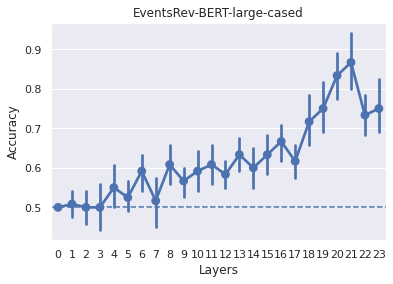

In [13]:
# Plotting
df_out = pd.DataFrame(out)
df_out = df_out.transpose()
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data = df_out)
ax.set(xlabel="Layers", ylabel = "Accuracy")
ax.axhline(0.5, linestyle="dashed")
ax.set_title("EventsRev-BERT-large-cased")
plt.show()

In [14]:
df_out.to_csv("EventsRev_BERT_large_cased")

Draft - DO NOT RUN!

In [ ]:
# for each of the 13 layers.

out = []
for layer in range(13):
    DT_vectors = []
    for sentence in range(len(sentence_DT)):
        DT_vectors.append(get_vector(sentence_DT[sentence], layer))
    vectors = np.array(DT_vectors)
    Accuracy = []
    for k in range(10):
        x_train, x_test, y_train, y_test = train_test_split(vectors, plausibility,
                                                            test_size=0.15)
        logreg = LogisticRegression()
        logreg.fit(x_train, y_train)
        y_pred = logreg.predict(x_test)
        Accuracy.append(metrics.accuracy_score(y_test, y_pred))
    print("layer", layer, statistics.mean(Accuracy))
    out.append(Accuracy)